In [6]:
!pip install -q datasets transformers evaluate wandb

In [7]:
from huggingface_hub import notebook_login

notebook_login()

In [204]:
human_parsing_dataset = "mattmdjaga/human_parsing_dataset"

In [205]:
from datasets import load_dataset

dataset = load_dataset(human_parsing_dataset)

In [206]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 17706
    })
})

In [207]:
from datasets import DatasetDict


dataset = dataset["train"].select(range(1000))

# Wrapping it back into a DatasetDict
dataset = DatasetDict({"train": dataset})

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 1000
    })
})


In [208]:
from datasets import DatasetDict

# Assuming dataset1 is already loaded
dataset = dataset.rename_column("image", "pixel_values")
dataset = dataset.rename_column("mask", "label")

dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

In [209]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

In [210]:
dataset = dataset.shuffle(seed=42)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [211]:
test_ds[0]

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x600>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=400x600>}

In [121]:
image = train_ds[0]
image

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x600>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=400x600>}

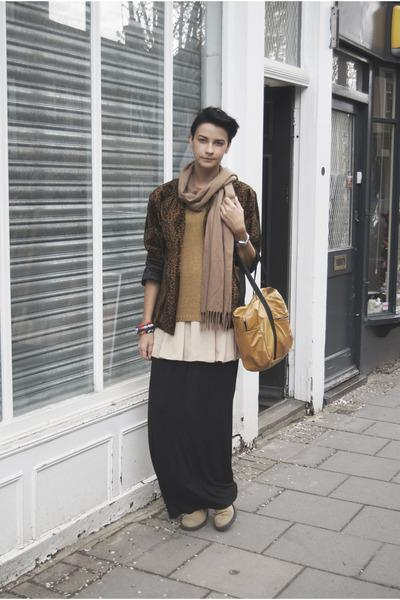

In [122]:
image['pixel_values']

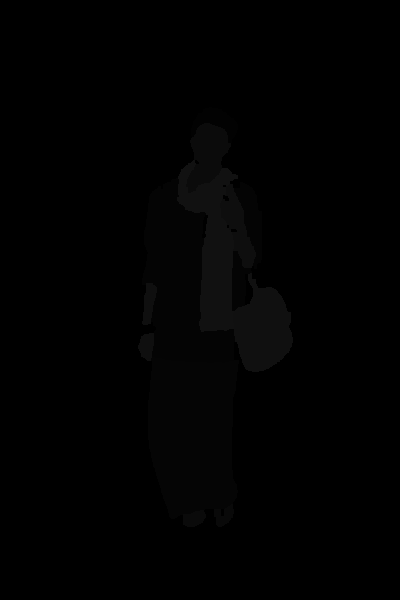

In [123]:
image['label']

In [124]:
import json
from huggingface_hub import hf_hub_download

filename = "id2label.json"
id2label = json.load(
    open(hf_hub_download(repo_id=human_parsing_dataset, filename=filename, repo_type="dataset"), "r")
)
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

Id2label: {0: 'Background', 1: 'Hat', 2: 'Hair', 3: 'Sunglasses', 4: 'Upper-clothes', 5: 'Skirt', 6: 'Pants', 7: 'Dress', 8: 'Belt', 9: 'Left-shoe', 10: 'Right-shoe', 11: 'Face', 12: 'Left-leg', 13: 'Right-leg', 14: 'Left-arm', 15: 'Right-arm', 16: 'Bag', 17: 'Scarf'}


In [125]:
color_codes = [
    [0, 0, 0],       # Background
    [128, 0, 0],     # Hat
    [255, 0, 0],     # Hair
    [0, 128, 0],     # Sunglasses
    [0, 255, 0],     # Upper-clothes
    [0, 0, 128],     # Skirt
    [0, 0, 255],     # Pants
    [128, 128, 0],   # Dress
    [128, 0, 128],   # Belt
    [0, 128, 128],   # Left-shoe
    [192, 192, 192], # Right-shoe
    [128, 128, 128], # Face
    [64, 0, 0],      # Left-leg
    [64, 64, 0],     # Right-leg
    [64, 0, 64],     # Left-arm
    [0, 64, 0],      # Right-arm
    [0, 64, 64],     # Bag
    [64, 64, 64]     # Scarf
]

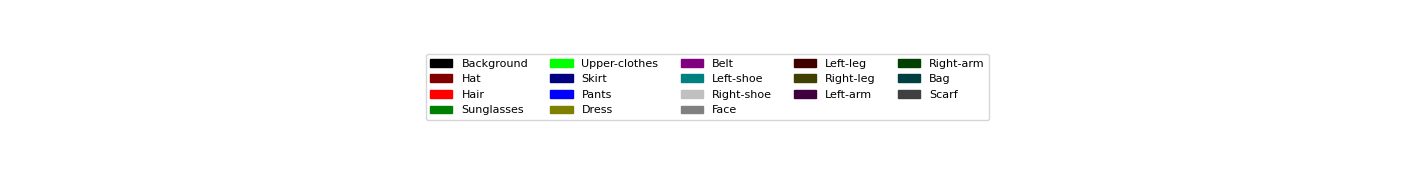

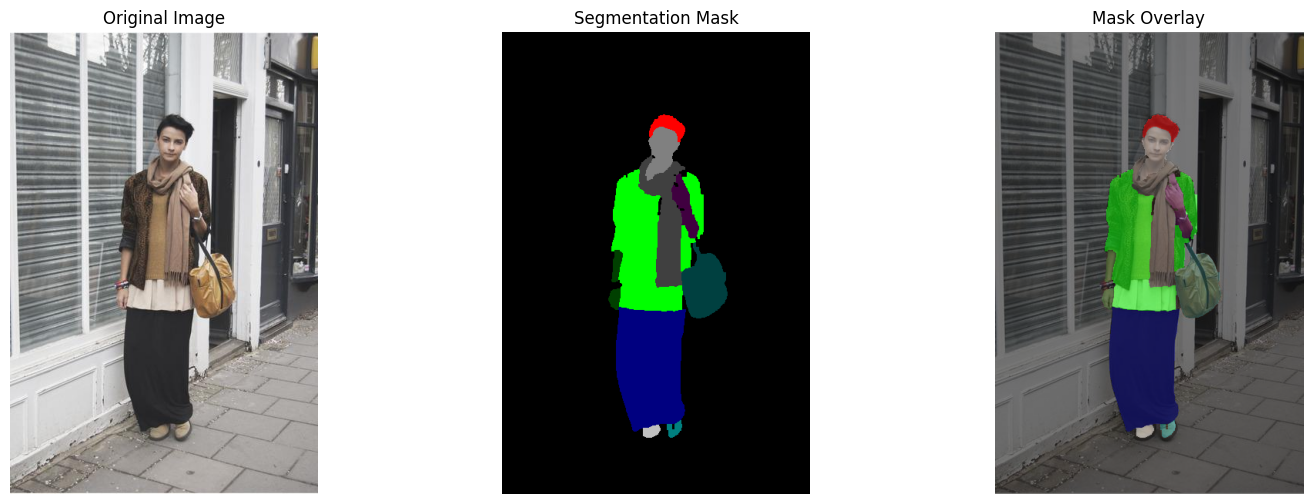

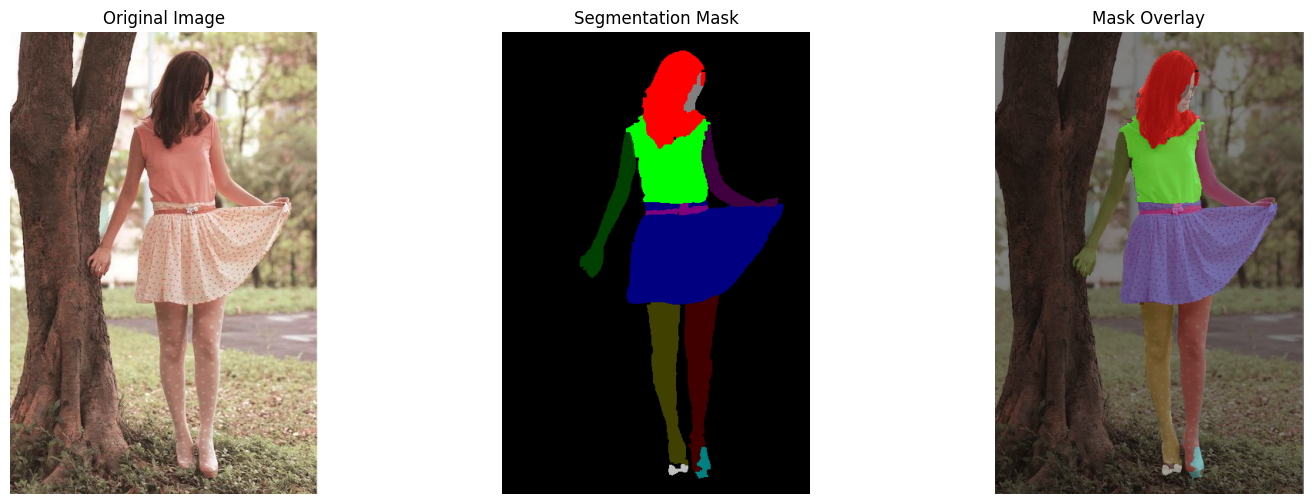

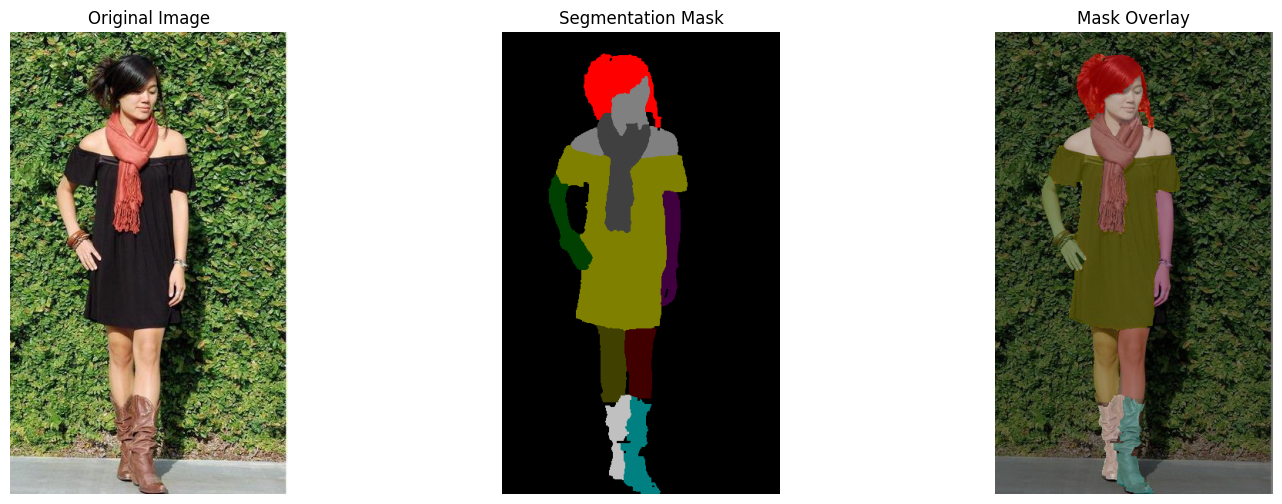

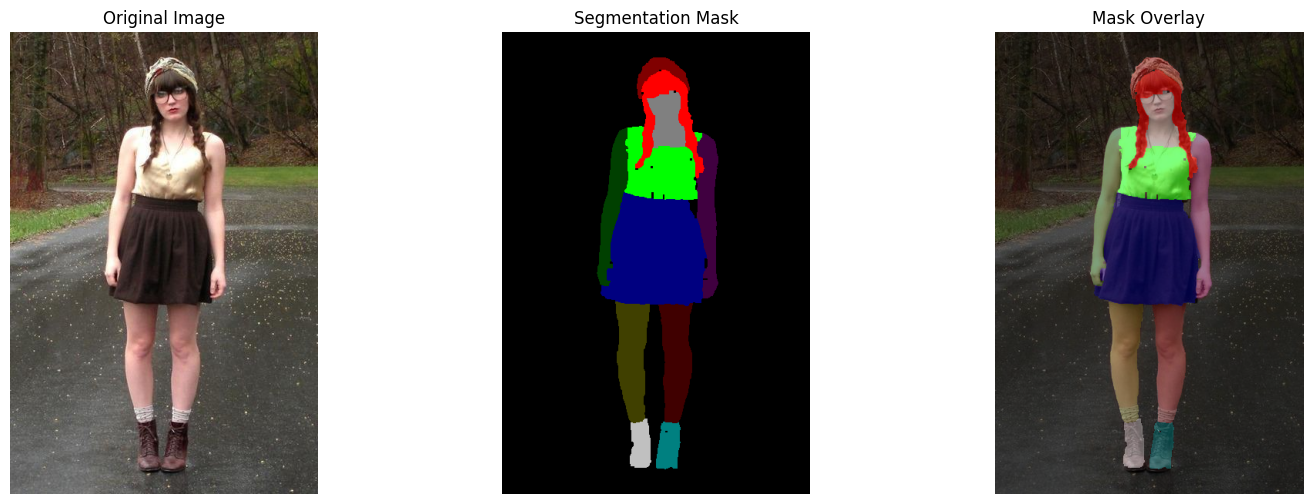

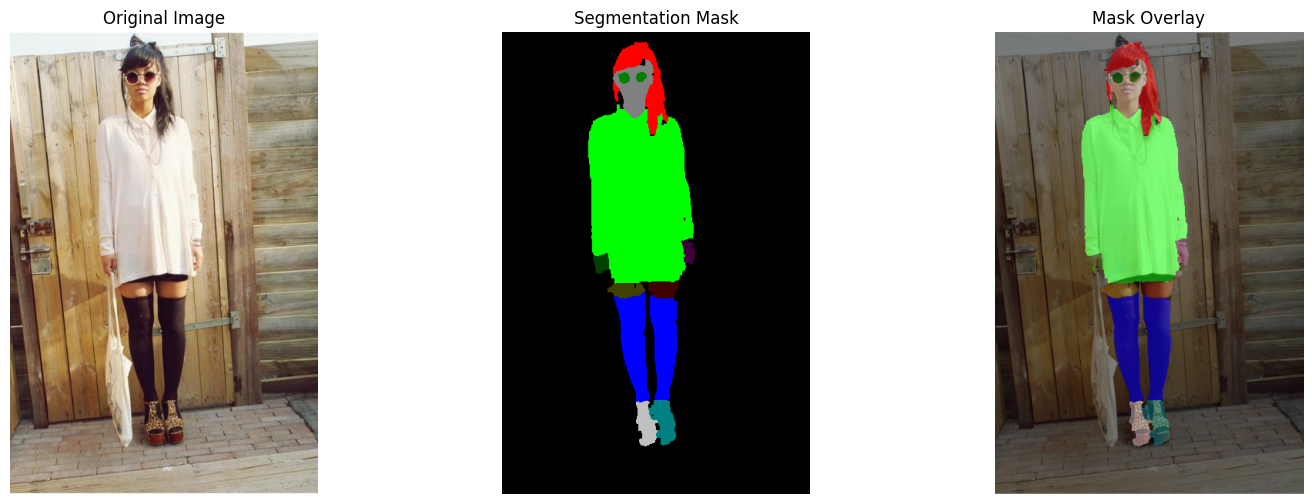

In [126]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches

# Create and show the legend separately
fig, ax = plt.subplots(figsize=(18, 2))

legend_patches = [
    patches.Patch(color=np.array(color) / 255, label=label)
    for label, color in zip(id2label.values(), color_codes)
]

ax.legend(handles=legend_patches, loc="center", bbox_to_anchor=(0.5, 0.5), ncol=5, fontsize=8)
ax.axis("off")

plt.show()

for i in range(5):
    image = train_ds[i]

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Show the original image
    ax[0].imshow(image["pixel_values"])
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    mask_np = np.array(image["label"])

    # Create a new empty RGB image
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # Assign colors to each value in the mask
    for label_id, color in enumerate(color_codes):
        colored_mask[mask_np == label_id] = color

    colored_mask_img = Image.fromarray(colored_mask, "RGB")

    # Show the segmentation mask
    ax[1].imshow(colored_mask_img)
    ax[1].set_title("Segmentation Mask")
    ax[1].axis("off")

    # Convert the original image to RGBA to support transparency
    image_rgba = image["pixel_values"].convert("RGBA")
    colored_mask_rgba = colored_mask_img.convert("RGBA")

    # Adjust transparency of the mask
    alpha = 128  # Transparency level (0 fully transparent, 255 fully opaque)
    image_2_with_alpha = Image.new("RGBA", colored_mask_rgba.size)
    for x in range(colored_mask_rgba.width):
        for y in range(colored_mask_rgba.height):
            r, g, b, a = colored_mask_rgba.getpixel((x, y))
            image_2_with_alpha.putpixel((x, y), (r, g, b, alpha))

    superposed = Image.alpha_composite(image_rgba, image_2_with_alpha)

    # Show the mask overlay
    ax[2].imshow(superposed)
    ax[2].set_title("Mask Overlay")
    ax[2].axis("off")

    plt.show()

## Visualize Class Occurrences

In [127]:
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 800
})

In [128]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.zeros(len(id2label))

for example in train_ds:
    mask_np = np.array(example["label"])
    unique, counts = np.unique(mask_np, return_counts=True)
    for u, c in zip(unique, counts):
        class_counts[u] += c

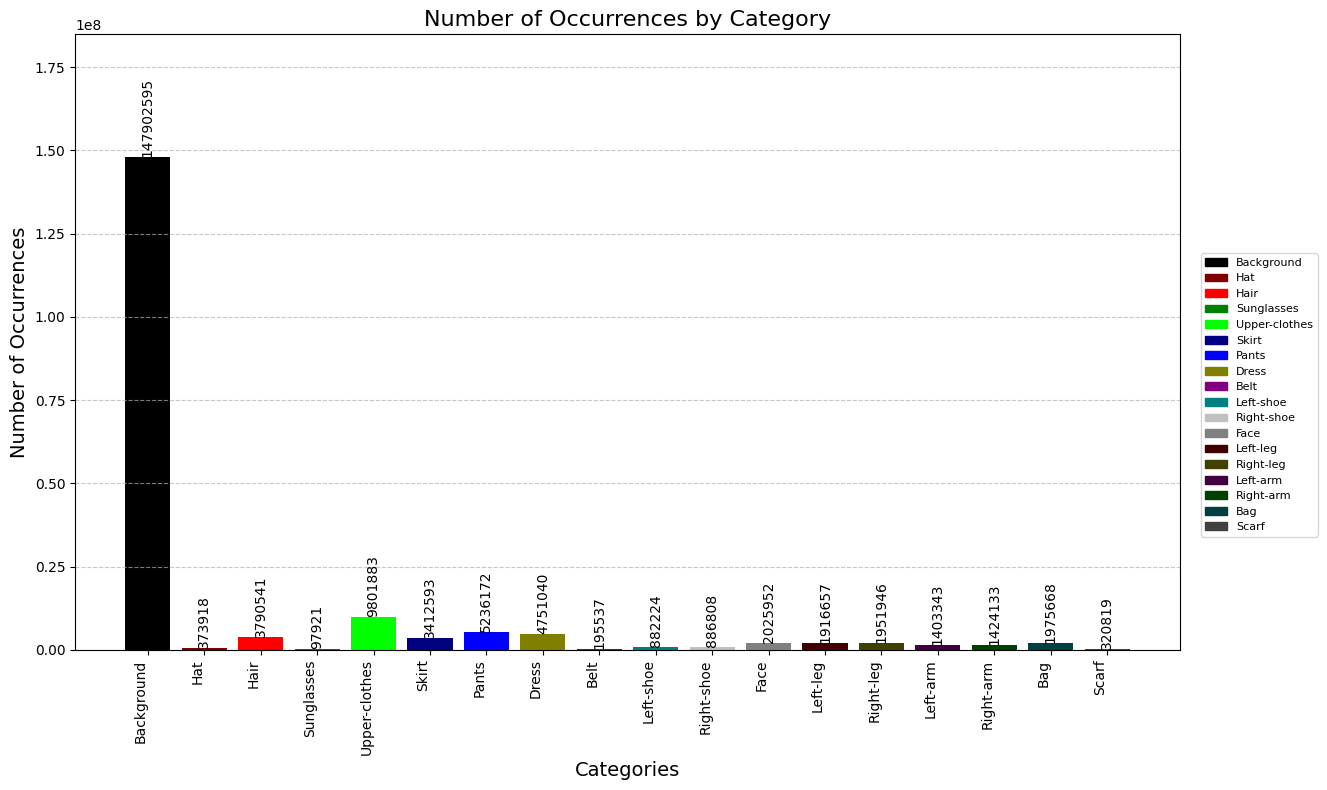

In [129]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import patches

labels = list(id2label.values())

# Normalize colors to be in the range [0, 1]
normalized_palette = [tuple(c / 255 for c in color) for color in color_codes]

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(range(len(labels)), class_counts, color=[normalized_palette[i] for i in range(len(labels))])

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha="right")

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Number of Occurrences by Category", fontsize=16)

ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust the y-axis limit
y_max = max(class_counts)
ax.set_ylim(0, y_max * 1.25)

for bar in bars:
    height = int(bar.get_height())
    offset = 10  # Adjust the text location
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + offset,
        f"{height}",
        ha="center",
        va="bottom",
        rotation=90,
        fontsize=10,
        color="black",
    )

fig.legend(
    handles=legend_patches, loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fontsize=8
)  # Adjust ncol as needed

plt.tight_layout()
plt.show()

## Initialize Image Processor and Add Data Augmentation with AlbumentationsNew Section

In [130]:
import albumentations as A
from transformers import SegformerImageProcessor

image_processor = SegformerImageProcessor()

albumentations_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.7),
        A.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=25, val_shift_limit=20, p=0.5),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.GaussNoise(var_limit=(10, 50), p=0.4),
    ]
)


def train_transforms(example_batch):
    augmented_images = [albumentations_transform(image=np.array(x))["image"] for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = image_processor(augmented_images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = image_processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [131]:
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 800
})

In [132]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "briaai/RMBG-1.4"
model = SegformerForSemanticSegmentation.from_pretrained(pretrained_model_name, id2label=id2label, label2id=label2id)

You are using a model of type SegformerForSemanticSegmentation to instantiate a model of type segformer. This is not supported for all configurations of models and can yield errors.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at briaai/RMBG-1.4 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight', 'encoder.block.0.0.attention.output.dense.bias', 'encoder.block.0.0.attention.output.dense.wei

In [137]:
from transformers import TrainingArguments

output_dir = "RMBG-human_parsing-finetuned"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=6e-5,
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to="none",
    remove_unused_columns=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [138]:
import evaluate

evaluate.logging.set_verbosity_error()

In [139]:
import torch
from torch import nn
import multiprocessing

metric = evaluate.load("mean_iou")


def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        # currently using _compute instead of compute: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        pred_labels = logits_tensor.detach().cpu().numpy()
        import warnings

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=image_processor.do_reduce_labels,
            )

        # add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

In [140]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

<ipython-input-140-c54af788501c>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [142]:
trainer.train()

TrainOutput(global_step=2000, training_loss=1.028851285636425, metrics={'train_runtime': 2784.192, 'train_samples_per_second': 5.747, 'train_steps_per_second': 0.718, 'total_flos': 2.8075773394944e+17, 'train_loss': 1.028851285636425, 'epoch': 20.0})

In [143]:
trainer.save_model()

In [144]:
trainer.push_to_hub()

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/osmanh/RMBG-human_parsing-finetuned/commit/1d412112265adb3c792cafb9c7c0436a8a0eb0c2', commit_message='End of training', commit_description='', oid='1d412112265adb3c792cafb9c7c0436a8a0eb0c2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/osmanh/RMBG-human_parsing-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='osmanh/RMBG-human_parsing-finetuned'), pr_revision=None, pr_num=None)

## Prediction

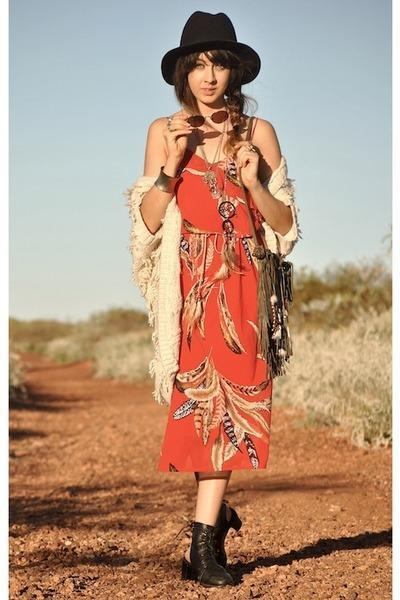

In [214]:
test_ds[0]['pixel_values']

In [222]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

image_segmentator = pipeline(
    "image-segmentation", model="osmanh/RMBG-human_parsing-finetuned", trust_remote_code=True)

results = image_segmentator(test_ds[0]['pixel_values'])

You are using a model of type segformer to instantiate a model of type SegformerForSemanticSegmentation. This is not supported for all configurations of models and can yield errors.
You are using a model of type segformer to instantiate a model of type SegformerForSemanticSegmentation. This is not supported for all configurations of models and can yield errors.
Some weights of BriaRMBG were not initialized from the model checkpoint at osmanh/RMBG-human_parsing-finetuned and are newly initialized: ['conv_in.bias', 'conv_in.weight', 'side1.bias', 'side1.weight', 'side2.bias', 'side2.weight', 'side3.bias', 'side3.weight', 'side4.bias', 'side4.weight', 'side5.bias', 'side5.weight', 'side6.bias', 'side6.weight', 'stage1.rebnconv1.bn_s1.bias', 'stage1.rebnconv1.bn_s1.num_batches_tracked', 'stage1.rebnconv1.bn_s1.running_mean', 'stage1.rebnconv1.bn_s1.running_var', 'stage1.rebnconv1.bn_s1.weight', 'stage1.rebnconv1.conv_s1.bias', 'stage1.rebnconv1.conv_s1.weight', 'stage1.rebnconv1d.bn_s1.bia

In [223]:
print(type(results))
print(results)

<class 'PIL.Image.Image'>
<PIL.Image.Image image mode=RGBA size=400x600 at 0x782FC6938550>


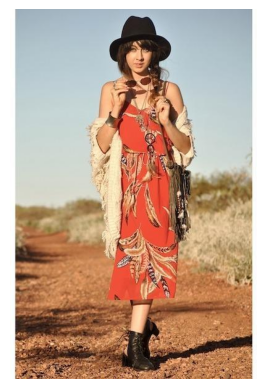

In [224]:
plt.imshow(test_ds[0]['pixel_values'])
plt.axis("off")
plt.show()

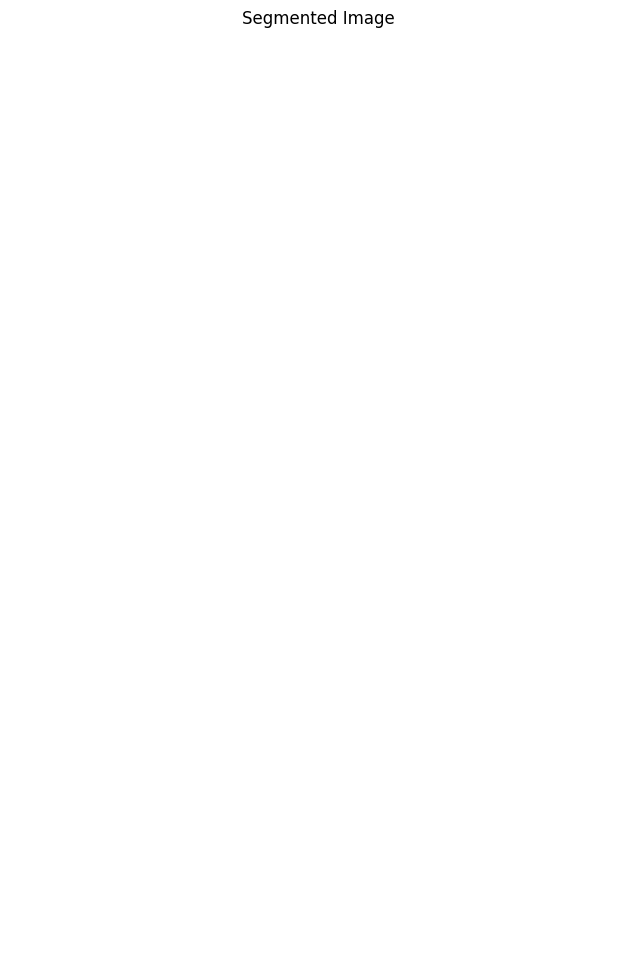

In [225]:
import matplotlib.pyplot as plt

# Display the segmented image
segmented_image = image_segmentator(test_ds[0]['pixel_values'])
plt.figure(figsize=(12, 12))
plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.axis("off")
plt.show()
